Simplest Palindrome with non-tied Dense.

Walk through pseudo-inverse and show how non-tied Dense are driven toward a pseudo-inverse relationship.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import nn
import keras
from keras import layers
from keras.datasets import mnist

Load up some MNIST digits

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
batch_size = 1024

11501568/11490434 [==============================] - 0s 0us/step


First, a basic 2-stage autoencoder for MNIST digits. Use all defaults, they're good.


In [3]:
def create_palindromic_model(use_prelu=True):
    input_img = keras.Input(shape=(784,))
    x = layers.Dense(128, kernel_initializer='glorot_uniform', use_bias=False, name='a')(input_img)
    x = layers.Dropout(0.2)(x)
    if use_prelu:
        x = layers.LeakyReLU()(x)
    x = layers.Dense(64, kernel_initializer='glorot_uniform', use_bias=False, name='b')(x)
    # x = layers.Dense(32, use_bias=False)(x)
    # x = layers.Dense(64, use_bias=False)(x)
    x = layers.Dense(128, use_bias=False, name='inv_b')(x)
    if use_prelu:
        x = layers.Lambda(lambda x: -x)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Lambda(lambda x: -x)(x)
    x = layers.Dense(784, use_bias=False, name='inv_a')(x)

    autoencoder = keras.Model(input_img, x)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    return autoencoder

Now let's train it.

In [4]:
num_epochs =  300  # @param {type: "slider", min:2, max:300}
autoencoder = create_palindromic_model()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=2048,
                shuffle=True,
                callbacks=[early_stopping],
                validation_data=(x_test, x_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 a (Dense)                   (None, 128)               100352    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 b (Dense)                   (None, 64)                8192      
                                                                 
 inv_b (Dense)               (None, 128)               8192      
                                                                 
 lambda (Lambda)             (None, 128)               0     

This is a terrible design, but it does work.

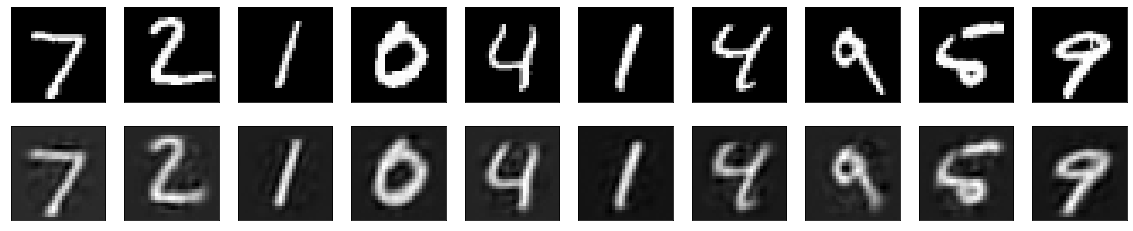

In [5]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

predicted_imgs = autoencoder.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [6]:
def get_layer(model, name):
    for layer in model.layers:
        if layer.name == name:
            return layer

def get_pair(model, forward, inverse):
    for layer in model.layers:
        if layer.name == forward:
            dense = layer
        elif layer.name == inverse:
            inverse_dense = layer
        
    weights = dense.get_weights()[0]
    print(len(weights))
    print('forward.shape', weights.shape)
    # print('b.shape', b.shape)
    inverse_weights = inverse_dense.get_weights()[0]
    print('inverse.shape', inverse_weights.shape)
    return np.asarray(weights, dtype='float64'), np.asarray(inverse_weights, dtype='float64')

def delta_gram(gram):
    print(gram.shape)
    ident = np.eye(gram.shape[0])
    return np.mean(np.abs(gram - ident))

def plot_gram(gram):
    fig, ax = plt.subplots()
    im = ax.imshow(gram)

784
forward.shape (784, 128)
inverse.shape (128, 784)
(128, 128)
0.09189586020525263
-2.541454743499456e-41


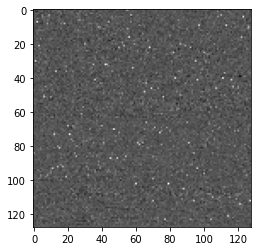

In [7]:
(forward, inverse) = get_pair(autoencoder, 'a', 'inv_a')
gram = np.matmul(inverse, forward)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(gram)


128
forward.shape (128, 64)
inverse.shape (64, 128)
(64, 64)
0.11836532888582753
-1.463570904478899e-13


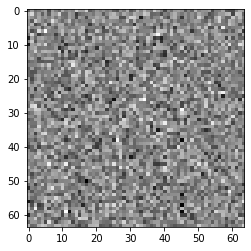

In [8]:
(forward, inverse) = get_pair(autoencoder, 'b', 'inv_b')
gram = np.matmul(inverse, forward)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(gram)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 a (Dense)                   (None, 128)               100352    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 b (Dense)                   (None, 64)                8192      
                                                                 
 inv_b (Dense)               (None, 128)               8192      
                                                                 
 lambda_2 (Lambda)           (None, 128)               0   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


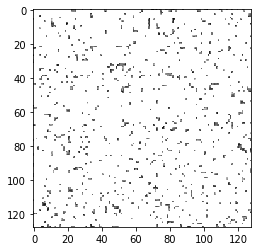

In [9]:
untrained = create_palindromic_model()
untrained.predict(x_test)
(forward, inverse) = get_pair(untrained, 'a', 'inv_a')
gram = np.matmul(inverse, forward)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(np.sqrt(gram))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


1.7879052647869394e+25


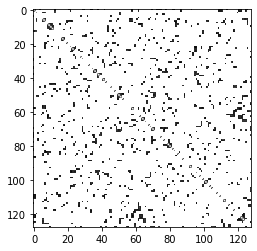

In [10]:
gram = np.matmul(inverse, np.transpose(inverse))
print(np.linalg.det(gram))
plot_gram(np.sqrt(gram))

In [11]:
# def create_palindromic_model():
#     kernel_init = 'glorot_uniform'
#     input_img = keras.Input(shape=(784,))
#     x = layers.Dense(128, kernel_initializer=kernel_init, use_bias=False, name='a')(input_img)
#     x = layers.Dense(64, kernel_initializer=kernel_init, use_bias=False, name='b')(x)
#     # x = layers.Dense(32, use_bias=False)(x)
#     # x = layers.Dense(64, use_bias=False)(x)
#     x = layers.Dense(128, kernel_initializer=kernel_init, use_bias=False, name='inv_b')(x)
#     x = layers.Dense(784, kernel_initializer=kernel_init, use_bias=False, name='inv_a')(x)

#     autoencoder = keras.Model(input_img, x)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.summary()
#     return autoencoder

In [12]:
class MonitorGram(tf.keras.callbacks.Callback):
    def __init__(self, forward, inverse):
        super(MonitorGram, self).__init__()
        self._forward = forward
        self._inverse = inverse
        self._grams = []

    def on_epoch_end(self, epoch, logs=None):
        forward = self._forward.get_weights()[0]
        inverse = self._inverse.get_weights()[0]
        gram = np.matmul(np.asarray(forward, dtype='float64'), np.asarray(inverse, dtype='float64'))
        det = np.linalg.det(gram)
        self._grams.append(det)

    def get_grams(self):
        return self._grams

In [13]:
num_epochs =  300  # @param {type: "slider", min:2, max:300}
autoencoder = create_palindromic_model(use_prelu=False)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
monitor_gram = MonitorGram(get_layer(autoencoder, 'inv_b'), get_layer(autoencoder, 'b'))

history = autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=2048,
                shuffle=True,
                callbacks=[early_stopping, monitor_gram],
                validation_data=(x_test, x_test))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 a (Dense)                   (None, 128)               100352    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 b (Dense)                   (None, 64)                8192      
                                                                 
 inv_b (Dense)               (None, 128)               8192      
                                                                 
 inv_a (Dense)               (None, 784)               100352    
                                                                 
Total params: 217,088
Trainable params: 217,088
Non-trainab

In [14]:
print(history)

In [15]:
grams = monitor_gram.get_grams()
print(grams)

[4.1098975336568045e-23, 3.194409685339674e-26, 5.296216019657896e-26, 3.4199100220197816e-26, 3.0453640709506486e-26, 4.039831300208122e-26, 5.334255683783966e-26, 6.93559870318955e-26, 8.607077709879054e-26, 1.252948250994472e-25, 1.90862155381661e-25, 2.84918349262826e-25, 4.484137164941519e-25, 6.170925685165024e-25, 8.56966259050963e-25, 9.650254074384378e-25, 9.831863172931984e-25, 9.609455764906749e-25, 6.62176778349039e-25, -1.7310625177261015e-25, -1.5722593337380504e-24, -3.541337237289377e-24, -6.191742426072929e-24, -9.657190415891632e-24, -1.340420879535958e-23, -1.4745991113505266e-23, -1.9580107122065665e-23, -2.0744463242374278e-23, -2.16159910560492e-23, -1.5283269511312576e-23, -1.7064843352318208e-23, -5.340571818934264e-24, -1.3281957070450138e-24, 1.0105848375918784e-24, 6.077046743292275e-24, 8.576843863657073e-24, 1.333953932602055e-23, 7.65951067383925e-24, 9.573371730987321e-24, 1.1417682617448235e-23, 9.208607381151632e-24, 8.498482148943865e-24, 7.76007518926

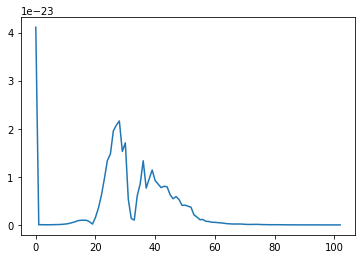

In [16]:
plt.plot(range(len(grams)), np.abs(grams))

In [17]:
def dual_plot(data1, data2, name1, name2):
    assert len(data1) == len(data2)
    xaxis = [x for x in range(len(data1))]
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()
    # make a plot
    ax.plot(xaxis, data1,
            color="red")
    # set x-axis label
    ax.set_xlabel("epoch", fontsize = 14)
    # set y-axis label
    ax.set_ylabel(name1,
                color="red",
                fontsize=14)
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(xaxis, data2,color="blue")
    ax2.set_ylabel(name2,color="blue",fontsize=14)
    plt.show()
    

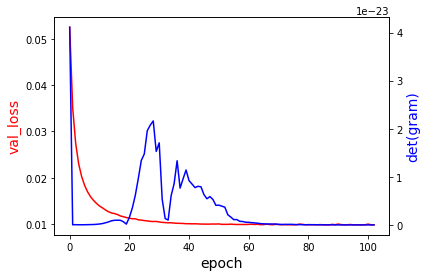

In [18]:
left = np.asarray(history.history['val_loss'], dtype='float64')
# left = np.abs(left[1:] - left[:-1])
right = np.abs(grams)
dual_plot(left, right, 'val_loss', 'det(gram)')

128
forward.shape (128, 784)
inverse.shape (784, 128)
(784, 784)
0.01614917733554404
0.0


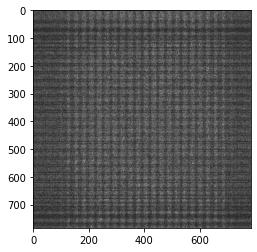

In [19]:
(forward, inverse) = get_pair(autoencoder, 'inv_a', 'a')
gram = np.matmul(inverse, forward)
print(delta_gram(gram))
print(np.linalg.det(gram))
plot_gram(np.sqrt(np.abs(gram)))
# plot_gram(np.abs(gram))

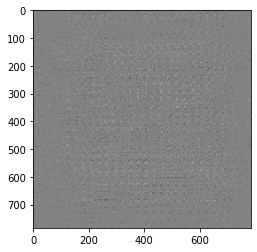

In [20]:
plot_gram(gram)

In [21]:
print(grams[-1])

8.395877750574296e-27


In [25]:
(forward, inverse) = get_pair(autoencoder, 'inv_b', 'b')


64
forward.shape (64, 128)
inverse.shape (128, 64)


In [26]:
ones = np.ones((forward.shape[0],), dtype='float64')
print(ones.shape)
projected = np.matmul(ones, forward)
print(projected.shape)
print(projected)

(64,)
(128,)
[ 0.29877569  1.14632418  0.38698027 -0.96762238  0.31137096 -1.23208326
  0.90448738 -0.55738263 -0.34379427  1.35684365  0.88593552  0.06352933
  0.26846815 -0.241548    1.18556559 -0.14520639 -1.02923181  0.02765496
  0.90851261 -0.35303981 -0.352489    0.55859423  0.67373303  0.43469013
 -0.48166765 -0.49996503  1.05840046 -0.49854878  0.42420847  0.93414146
 -0.42578029 -0.66250195  0.82364748  0.34070327  1.18571494  0.52864131
  0.27957598  0.54208932 -0.46520368 -0.9369368  -0.75865643  0.49805997
 -0.43148719 -0.99433454 -0.87290242 -0.79359127  0.12934839 -0.791429
 -2.06468885  0.72222383 -0.1893589   0.54556775 -0.92534472  0.31649272
  0.55124042 -0.61558758 -0.2017346  -0.97888573  0.74505045  1.18475598
 -1.04853976 -0.04761836 -1.14366902 -0.32436878 -0.54592754  1.03921436
 -0.25156674 -0.24484374 -0.67740158  0.49773767  0.53063331 -0.3599709
 -0.63408572  0.7163821   0.86947051  1.07793326 -0.17121425 -0.97862205
 -0.13276911  1.14037627  0.51336004 -2.0

In [27]:
inverted = np.matmul(projected, inverse)
print(inverted.shape)
print(inverted)

(64,)
[-0.25578384 -1.3185126   1.32424347 -1.99109299  0.3181788  -0.12685146
  0.43543493  1.22559746  0.66058775  0.2489193   0.31899917  0.14567151
 -0.63807326 -0.27535858 -0.23950012 -0.57394836  0.71724236 -0.19062426
  1.31944977 -0.57608291  0.91838192  0.36782454 -1.21078434  0.70430799
 -1.18389204 -0.46119197 -1.18397279  0.09560293  0.28971795 -1.23247022
 -0.55809007 -1.56998587 -0.75493851 -0.72629882 -0.74463316 -0.23232192
  0.19310135 -0.23034537 -0.97657311 -0.49104887  1.47977577  1.28653105
 -1.19527278  2.01239819  0.29598332  0.84776464 -0.01359666  0.59082217
 -0.53504552 -0.36176292 -0.04591254 -1.22829113  0.29488432  0.58173517
  1.4100555   0.16978906 -0.19731407 -0.66494052  0.55288178 -0.54173247
 -0.81014486  0.41242591 -0.160462    1.12849573]


In [28]:
print(np.mean(inverted))

-0.049219486020192084


In [29]:
print(np.mean(projected))

0.03306454817189319
